I find that there is not much of an a repeated action bias in the actual data, in human responses, or in the DQN responses. If anything people seem to be strangely biased (very slightly) to not repeating their action. This is strange because usually people will tend to repeat their actions at least in more traditional bandit tasks.

# Setup

In [8]:
import sys
sys.path.append('../gym_art')

from PIL import Image

from paintings import PaintingEnv
import numpy as np
import pandas as pd
from collections import defaultdict, namedtuple, deque

from tqdm import tqdm
import plotnine as pn

from scipy import stats

In [22]:
def prop_repeat(actions):
    """Returns the proportion of repeats given a set of actions taken"""
    labs = np.abs(np.diff(actions))
    labs = labs[labs<2]
    return np.mean((labs==0))

# Actual Side Bias

I look into if within the data there is any bias to the action taken. Might the optimal choice be to one side or another?

In [ ]:
env = PaintingEnv(state_type='object') # Outputs a top-layer of Inception with max-pooling

In [42]:
state, reward, done, info = env.reset(full_reset=False) # reset environment

In [45]:
if info['left']['display_value'] > info['right']['display_value']:
    action = 0
else:
    action = 1

True

In [49]:
# Repeat this 25 times to get distribution of repeats
actions = []
for _ in tqdm(range(25)):
    state, reward, done, info = env.reset(full_reset=True) # reset environment
    score = 0
    episode_actions = []
    for t in range(env.n_trials - 1):
        if info['left']['display_value'] > info['right']['display_value']:
            action = 0
        else:
            action = 1
        next_state, reward, done, info = env.step(action)   # send action to environment
        score += reward
        episode_actions.append(action)
        if done:
            break
    actions.append(episode_actions)

100%|███████████████████████████████████████████| 25/25 [01:42<00:00,  4.09s/it]


In [51]:
batch_prop_repeats = np.array([ prop_repeat(a_s) for a_s in actions ])

In [52]:
batch_prop_repeats.mean()

0.5081818181818182

In [53]:
stats.ttest_1samp(batch_prop_repeats, 0.5)

Ttest_1sampResult(statistic=0.9843024095729692, pvalue=0.33478647145727447)

In [54]:
df = pd.DataFrame({'batch': list(range(1,len(batch_prop_repeats)+1)), 'prop_repeats': batch_prop_repeats})

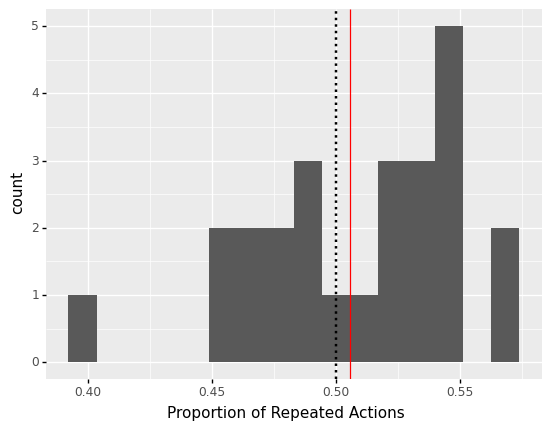

<ggplot: (8768340364174)>

In [58]:
(pn.ggplot(df, pn.aes(x='prop_repeats')) + 
 pn.geom_histogram(bins=16) + 
 pn.geom_vline(xintercept=np.mean(episode_prop_repeats), color='red') +
 pn.geom_vline(xintercept=0.5, color='black', linetype='dotted', size=1) + 
 pn.xlab('Proportion of Repeated Actions'))

# Side Bias of People

I want to investigate if people have any bias in the side that they choose.

The result is that people don't appear to have a strong bias. On average people repeat their action with a probability of 0.474. Though the value does appear to be significantly different from 0.5 (chance). 

## Setup

In [2]:
dat = pd.read_csv("y_data_catlearn.csv", index_col=0).reset_index(drop=True)
dat.head()

,trial,subject,ttype,run,gallery_left,gallery_right,art_left,art_right,stim_left,stim_right,...,chosen_val,chosen_gal,chosen_art,chosen_stim,unchosen_val,unchosen_gal,unchosen_art,unchosen_stim,chosen_val_grp,unchosen_val_grp
0,1,29svyahw,learn_value,1,Cordelia,Cordelia,Mon,Mon,Monb2n.jpeg,Monb1n.jpeg,...,80.0,Cordelia,Mon,Monb2n.jpeg,60.0,Cordelia,Mon,Monb1n.jpeg,high,high
1,2,29svyahw,learn_value,1,Cordelia,Cordelia,Mon,Mon,Mondb2.jpeg,Mondb3.jpeg,...,60.0,Cordelia,Mon,Mondb2.jpeg,40.0,Cordelia,Mon,Mondb3.jpeg,high,high
2,3,29svyahw,learn_value,1,Cordelia,Marina,Mon,Rot,Monb3n.jpeg,Rota1n.jpeg,...,20.0,Marina,Rot,Rota1n.jpeg,60.0,Cordelia,Mon,Monb3n.jpeg,low,high
3,4,29svyahw,learn_value,1,Marina,Marina,Rot,Rot,Rothb2.jpeg,Rota1n.jpeg,...,20.0,Marina,Rot,Rothb2.jpeg,20.0,Marina,Rot,Rota1n.jpeg,low,low
4,5,29svyahw,learn_value,1,Marina,Cordelia,Rot,Mon,Rothb2.jpeg,Monb2n.jpeg,...,80.0,Cordelia,Mon,Monb2n.jpeg,20.0,Marina,Rot,Rothb2.jpeg,high,low


In [4]:
actions = dat.loc[dat.subject == '29svyahw', 'choice'].astype('category').cat.codes
prop_repeat(actions)

0.4090909090909091

## Measure Repitition

In [5]:
# Get the proportion of repeat actions taken per subject
subj_repeats = dat.groupby('subject').apply(lambda x: prop_repeat(x.choice.astype('category').cat.codes))

In [6]:
subj_repeats

subject
0c5elj2l    0.539326
0q4hzu7r    0.494382
0rx8wkq0    0.438202
1w1m6w5v    0.393258
1x880j6k    0.404494
              ...   
xskb7u61    0.494382
yko5at2v    0.359551
yv9953n7    0.561798
z61jpn72    0.409091
zr94qfhc    0.528090
Length: 100, dtype: float64

In [12]:
subj_repeats.mean()

0.4742176511335752

In [13]:
subj_repeats.median()

0.48314606741573035

In [10]:
stats.ttest_1samp(subj_repeats, 0.5)

Ttest_1sampResult(statistic=-3.2517635090758112, pvalue=0.0015685218597457338)

/Users/czarrar/Dropbox/ABD/Areas/Lab_Work/paint_cats/myenv_paintcats/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 16'. Pick better value with 'binwidth'.


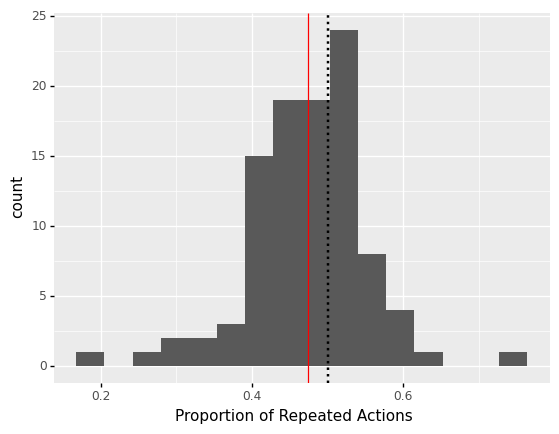

<ggplot: (8768491311086)>

In [7]:
df = subj_repeats.to_frame(name='x')
(pn.ggplot(df, pn.aes(x='x')) + 
 pn.geom_histogram() + 
 pn.geom_vline(xintercept=np.mean(subj_repeats), color='red') +
 pn.geom_vline(xintercept=0.5, color='black', linetype='dotted', size=1) + 
 pn.xlab('Proportion of Repeated Actions'))

# The Machines

Does the DQN have any action bias? It seems like there is really no bias overall. There seems to be a bias towards repeating the action towards the end.

In [14]:
env = PaintingEnv(state_type='object') # Outputs a top-layer of Inception with max-pooling

2022-02-12 13:21:20.814366: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
import agent
#from importlib import reload
#agent = reload(agent)
Agent = agent.Agent

In [17]:
def dqn(agent, n_episodes=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, train_mode=True, 
        ckpt_path='pth_checkpoints/checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        agent (Agent): The agent
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train_mode (bool): if 'True' set environment to training mode
    """
    actions = []
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    moving_avgs = []                   # list of moving averages
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        episode_actions = []
        state, reward, done, info = env.reset(full_reset=False) # reset environment
        score = 0
        for t in range(env.n_trials - 1):
            pp_state = np.hstack(state)                 # from raw pixels to high-lvl visual reps
            action = agent.act(pp_state, eps)                   # select an action
            next_state, reward, done, info = env.step(action)   # send action to environment
            pp_next_state = np.hstack(next_state)       # from raw pixels to high-lvl visual reps
            agent.step(pp_state, action, reward, pp_next_state, done) # learning step
            state = next_state
            score += reward
            episode_actions.append(action)
            if done:
                break
        actions.append(episode_actions)
        mean_score = score/t # keep scores in range of 0-1, allow comparison to humans above
        scores_window.append(mean_score)          # save most recent score to window
        scores.append(mean_score)                 # save most recent score to total
        moving_avg = np.mean(scores_window)  # calculate moving average
        moving_avgs.append(moving_avg)       # save most recent moving average
        eps = max(eps_end, eps_decay*eps)    # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg), end="")
        if i_episode % 5 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg))
    return scores, moving_avgs, actions

In [27]:
config_dict = {
    'seed': 42, 
    'buffer_size': int(1e2), 
    'batch_size': 32, 
    'gamma': 0,  # 0 gamma
    'tau': 1e-2, 
    'loss_type': 'huber',
    'gradient_clip': None, 
    'update_every': 4, 
    'lr': 5e-4, 
    'fc1_units': 64, 
    'fc2_units': 32, 
    'use_ddqn': False,
    'use_dueling': False, 
    'use_per': False,
    'per_a': 0.5, 
    'per_beta': 0.5
}
agent = Agent(state_size=2048*2, action_size=2, config_dict=config_dict)
scores, avgs, actions = dqn(agent, n_episodes=100, eps_decay=0.98, eps_end=0.1)

Episode 5	Average Score: 0.41
Episode 10	Average Score: 0.41
Episode 15	Average Score: 0.42
Episode 20	Average Score: 0.42
Episode 25	Average Score: 0.42
Episode 30	Average Score: 0.42
Episode 35	Average Score: 0.43
Episode 40	Average Score: 0.43
Episode 45	Average Score: 0.43
Episode 50	Average Score: 0.44
Episode 55	Average Score: 0.44
Episode 60	Average Score: 0.44
Episode 65	Average Score: 0.45
Episode 70	Average Score: 0.45
Episode 75	Average Score: 0.45
Episode 80	Average Score: 0.46
Episode 85	Average Score: 0.46
Episode 90	Average Score: 0.46
Episode 95	Average Score: 0.46
Episode 100	Average Score: 0.46


In [31]:
episode_prop_repeats = np.array([ prop_repeat(a_s) for a_s in actions ])

In [33]:
episode_prop_repeats.mean()

0.5056818181818182

In [32]:
stats.ttest_1samp(episode_prop_repeats, 0.5)

Ttest_1sampResult(statistic=0.9822994862575117, pvalue=0.328346840332578)

In [37]:
df = pd.DataFrame({'episode': list(range(1,len(episode_prop_repeats)+1)), 'prop_repeats': episode_prop_repeats})

/Users/czarrar/Dropbox/ABD/Areas/Lab_Work/paint_cats/myenv_paintcats/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 11'. Pick better value with 'binwidth'.


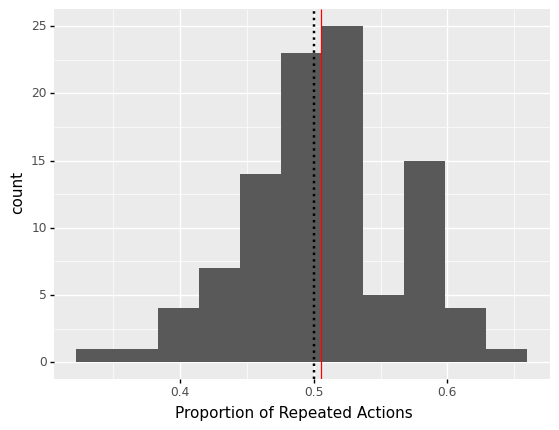

<ggplot: (8768494592431)>

In [38]:
(pn.ggplot(df, pn.aes(x='prop_repeats')) + 
 pn.geom_histogram() + 
 pn.geom_vline(xintercept=np.mean(episode_prop_repeats), color='red') +
 pn.geom_vline(xintercept=0.5, color='black', linetype='dotted', size=1) + 
 pn.xlab('Proportion of Repeated Actions'))

/Users/czarrar/Dropbox/ABD/Areas/Lab_Work/paint_cats/myenv_paintcats/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


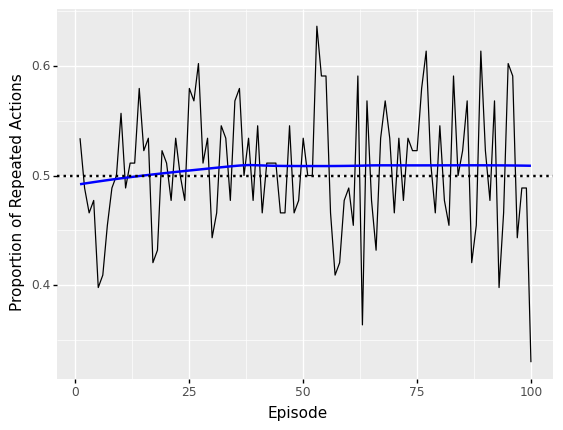

<ggplot: (8768370883828)>

In [41]:
(pn.ggplot(df, pn.aes(x='episode', y='prop_repeats')) + 
 pn.geom_line() + pn.geom_smooth(color='blue') +
 pn.geom_hline(yintercept=0.5, color='black', linetype='dotted', size=1) + 
 pn.ylab('Proportion of Repeated Actions') +
 pn.xlab('Episode')
)